<a href="https://colab.research.google.com/github/budhiacharya/AI-Lesson/blob/main/Assign_11_AI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment 11: Image Classification Using Random Forest

In [1]:
# Install Necessary Libraries
!pip install gitpython --quiet
!pip install scikit-image --quiet

import git
import os
import shutil
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    accuracy_score
)
from sklearn.utils import Bunch

from skimage.io import imread
from skimage.transform import resize
import skimage.io

In [2]:
# 1. Dataset Selection & Download (I am using a GitHub repo)

repo_url = 'https://github.com/Abhishek-Arora/Image-Classification-Using-SVM.git'
repo_dir = 'Image-Classification-Using-SVM'

if os.path.exists(repo_dir):
    shutil.rmtree(repo_dir)

git.Repo.clone_from(repo_url, repo_dir, branch='master')
data_dir = "/content/Image-Classification-Using-SVM/images/"

In [3]:
# 2. Helper function: Load and preprocess images
# Loads images
# Resizes to uniform dimension
# Normalizes pixel values

def load_image_files(container_path, dimension=(64, 64)):
    image_dir = Path(container_path)
    folders = [directory for directory in image_dir.iterdir() if directory.is_dir()]
    categories = [fo.name for fo in folders]

    images = []
    flat_data = []
    target = []

    for label, folder in enumerate(folders):
        for file in folder.iterdir():
            img = skimage.io.imread(file)
            # Resize to fixed dimension, convert to float in [0,1]
            img_resized = resize(img, dimension, anti_aliasing=True, mode='reflect')
            # Flatten to 1D feature vector
            flat_data.append(img_resized.flatten())
            images.append(img_resized)
            target.append(label)

    flat_data = np.array(flat_data, dtype=np.float32)  # normalized features
    target = np.array(target)
    images = np.array(images, dtype=np.float32)

    return Bunch(
        data=flat_data,
        target=target,
        target_names=categories,
        images=images,
        DESCR="Image Classification Dataset"
    )

In [4]:
# Load dataset
image_dataset = load_image_files(data_dir, dimension=(64, 64))

X = image_dataset.data          # features
y = image_dataset.target        # labels
class_names = image_dataset.target_names

print("Data shape:", X.shape)
print("Number of classes:", len(class_names))
print("Classes:", class_names)

Data shape: (309, 12288)
Number of classes: 5
Classes: ['soccer_ball', 'pizza', 'dalmatian', 'dollar_bill', 'sunflower']


In [5]:
# Train–Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.3,
    random_state=42,
    stratify=y
)

print("Train set:", X_train.shape, "Test set:", X_test.shape)

Train set: (216, 12288) Test set: (93, 12288)


2. Model Training:

In [6]:
# 4. Random Forest with GridSearchCV
rf_param_grid = {
    "n_estimators": [50, 100],
    "max_depth": [None, 10, 20],
    "min_samples_split": [2, 5],
    "min_samples_leaf": [1, 2],
}

rf_clf = RandomForestClassifier(random_state=42)

rf_grid = GridSearchCV(
    estimator=rf_clf,
    param_grid=rf_param_grid,
    cv=3,
    scoring="accuracy",
    n_jobs=-1,
    verbose=1
)

rf_grid.fit(X_train, y_train)

print("\nBest Random Forest Parameters:")
print(rf_grid.best_params_)

best_rf = rf_grid.best_estimator_

Fitting 3 folds for each of 24 candidates, totalling 72 fits

Best Random Forest Parameters:
{'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}


 3. Model Evaluation (Random Forest)


Random Forest Accuracy: 0.7634408602150538

Random Forest Classification Report:
              precision    recall  f1-score   support

 soccer_ball       0.67      0.75      0.71        16
       pizza       0.69      0.69      0.69        16
   dalmatian       0.74      0.70      0.72        20
 dollar_bill       0.80      0.80      0.80        15
   sunflower       0.88      0.85      0.86        26

    accuracy                           0.76        93
   macro avg       0.75      0.76      0.75        93
weighted avg       0.77      0.76      0.76        93



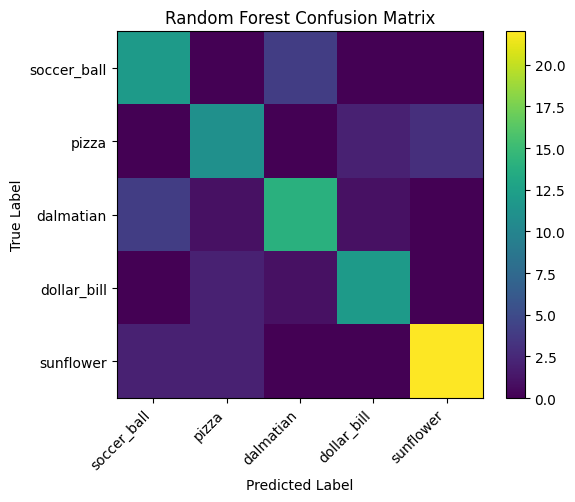

In [7]:
y_pred_rf = best_rf.predict(X_test)

print("\nRandom Forest Accuracy:", accuracy_score(y_test, y_pred_rf))
print("\nRandom Forest Classification Report:")
print(classification_report(y_test, y_pred_rf, target_names=class_names))

cm_rf = confusion_matrix(y_test, y_pred_rf)

plt.figure(figsize=(6, 5))
plt.imshow(cm_rf, interpolation="nearest")
plt.title("Random Forest Confusion Matrix")
plt.colorbar()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45, ha="right")
plt.yticks(tick_marks, class_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()

4. Feature Importance Visualization (Random Forest)

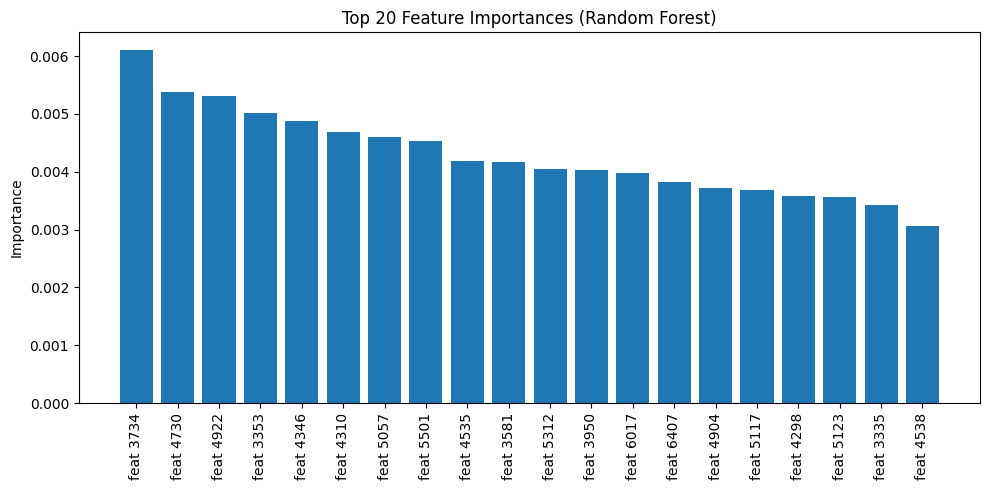

In [8]:
# Top 20 most important features
importances = best_rf.feature_importances_
indices = np.argsort(importances)[::-1][:20]  # indices of top 20 features

plt.figure(figsize=(10, 5))
plt.bar(range(len(indices)), importances[indices])
plt.xticks(range(len(indices)), [f"feat {i}" for i in indices], rotation=90)
plt.title("Top 20 Feature Importances (Random Forest)")
plt.ylabel("Importance")
plt.tight_layout()
plt.show()

# Note: For image data these "features" are pixels; importance is still valid
# but not very interpretable visually. For the assignment, this bar plot is enough.

5. Prediction on New Images

In [12]:
def preprocess_single_image(image_path, dimension=(64, 64)):

    img = skimage.io.imread(image_path)
    img_resized = resize(img, dimension, anti_aliasing=True, mode='reflect')
    flat = img_resized.flatten().astype(np.float32)
    return flat

def predict_image_class(image_path, model, class_names, dimension=(64, 64)):
    """
    Predict the class of a new image using the trained model.
    """
    features = preprocess_single_image(image_path, dimension)
    features = features.reshape(1, -1)  # model expects 2D array
    pred_label = model.predict(features)[0]
    pred_class = class_names[pred_label]
    return pred_class

6. Bonus: Comparing with SVM

Fitting 3 folds for each of 6 candidates, totalling 18 fits

Best SVM Parameters:
{'C': 10, 'gamma': 0.0001, 'kernel': 'rbf'}

SVM Accuracy: 0.7849462365591398

SVM Classification Report:
              precision    recall  f1-score   support

 soccer_ball       0.67      0.62      0.65        16
       pizza       0.93      0.88      0.90        16
   dalmatian       0.68      0.65      0.67        20
 dollar_bill       0.71      0.80      0.75        15
   sunflower       0.89      0.92      0.91        26

    accuracy                           0.78        93
   macro avg       0.78      0.77      0.77        93
weighted avg       0.78      0.78      0.78        93



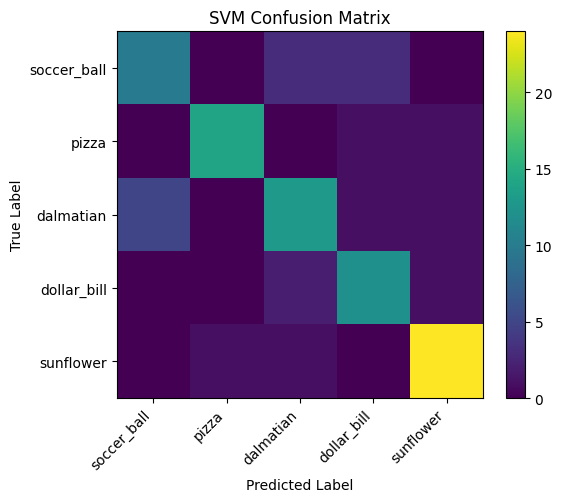

In [13]:
svm_param_grid = [
    {"C": [1, 10], "kernel": ["linear"]},
    {"C": [1, 10], "gamma": [0.001, 0.0001], "kernel": ["rbf"]},
]

svm_clf = SVC()

svm_grid = GridSearchCV(
    estimator=svm_clf,
    param_grid=svm_param_grid,
    cv=3,
    scoring="accuracy",
    n_jobs=-1,
    verbose=1
)

svm_grid.fit(X_train, y_train)

print("\nBest SVM Parameters:")
print(svm_grid.best_params_)

best_svm = svm_grid.best_estimator_

y_pred_svm = best_svm.predict(X_test)

print("\nSVM Accuracy:", accuracy_score(y_test, y_pred_svm))
print("\nSVM Classification Report:")
print(classification_report(y_test, y_pred_svm, target_names=class_names))

cm_svm = confusion_matrix(y_test, y_pred_svm)

plt.figure(figsize=(6, 5))
plt.imshow(cm_svm, interpolation="nearest")
plt.title("SVM Confusion Matrix")
plt.colorbar()
plt.xticks(tick_marks, class_names, rotation=45, ha="right")
plt.yticks(tick_marks, class_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()

In [15]:
import joblib

# Save the best Random Forest estimator
joblib.dump(rf_grid.best_estimator_, "RF_image_model.pkl")

print("Model saved successfully!")

Model saved successfully!
